# Wine reviews

## Preparation

### Download

In [2]:
from google.colab import files

! pip install -q kaggle
! pip install lazypredict
! pip install xgboost
! pip install nltk
! pip install geopandas
import geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 11.0 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source 

In [3]:
files.upload()

KeyboardInterrupt: ignored

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download zynicide/wine-reviews

In [ ]:
! unzip -n wine-reviews.zip

### Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Helper functions

In [6]:
def prepare_split_dataset(df, X_columns, y_column):
    def onehot_when_needed(df):
        result = []
        for column in df.columns:
            current_column = df[column]
            if not pd.api.types.is_numeric_dtype(df[column]):
                current_column = pd.get_dummies(df[column], prefix=column)
            result.append(current_column)
        return pd.concat(result, axis=1)
  
    # def get_duplicate_columns(df):
    #     duplicateColumnNames = set()
    #     for x in range(df.shape[1]):
    #         col = df.iloc[:, x]
    #         for y in range(x + 1, df.shape[1]):
    #             otherCol = df.iloc[:, y]
    #             if col.equals(otherCol):
    #                 duplicateColumnNames.add(df.columns.values[y])
    #     return list(duplicateColumnNames)

    X = onehot_when_needed(df[X_columns])
    # X = df[X_columns]
    y = np.asarray(df[y_column]).reshape(-1, 1)
    return X, y

### Load, prepare and split dataset

In [ ]:
! pwd

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# load file with index row
# df = pd.read_csv('winemag-data-130k-v2.csv', sep=',', index_col=0)
df = pd.read_csv('/content/drive/MyDrive/Studia/Projekt_ML/winemag-data-130k-v2-geo.csv', sep=',', index_col=0)

In [21]:
# Get only first 5000
# df = df.loc[:5000, :]

In [22]:
# Drop NaNs
# df = df.dropna()
# Maybe only for points?
# df = df[df['points'].notna()]

In [16]:
X, y = prepare_split_dataset(df, ['country', 'province', 'variety', 'price'], 'points')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

### Data research

In [17]:
# Get types of all columns
df.dtypes
# We have objects, because of NaNs

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

In [ ]:
# Relation between points and price
plt.scatter(x=df['points'], y=df['price'])

## Geo location

### Prepare

In [11]:
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim

### Helpers

In [ ]:
import math

In [ ]:
def to_3d_v4(lat, long):
    longitude = math.radians(lat)
    latitude = math.radians(long)

    return (
        math.cos(latitude) * math.cos(longitude),
        math.cos(latitude) * math.sin(longitude),
        math.sin(latitude)
    )

In [ ]:
def get_loc(orig_df):
    geolocator = Nominatim(user_agent="wine reviews")

    def findGeocode(loc):
        try:
            return geolocator.geocode(loc)
        except:
            return None
 
    longitudes = []
    latitudes = []
    Xs = []
    Ys = []
    Zs = []
    cache = {}
    df = orig_df.copy()
    
    for row in tqdm(df.iterrows()):
        keys = [row[1]["region_1"], row[1]["province"], row[1]["country"]]
        # try to find coordinates of values above in this order
        for key in keys:
            if key is not np.nan:
                coords = cache.get(key) # this returns None if value is not yet cached
                if not coords:
                    loc = findGeocode(key)
                    if loc:
                        coords = {'latitude': loc.latitude, 'longitude': loc.longitude}
                        break
        
        if not coords: # maybe you haven't found
            latitudes.append(None)
            longitudes.append(None)
        else:
            # print(f'wkladam: {type(coords)}')
            x,y,z = to_3d_v4(coords['latitude'], coords['longitude'])
            Xs.append(x)
            Ys.append(y)
            Zs.append(z)
            latitudes.append(coords['latitude'])
            longitudes.append(coords['longitude'])
            cache[key] = coords

    df['latitude'] = latitudes
    df['longitude'] = longitudes
    df['X'] = Xs
    df['Y'] = Ys
    df['Z'] = Zs
    # df['coordinates'] = final_coords
    return df

In [ ]:
geo_df = get_loc(df[:2000])

In [ ]:
geo_df.to_csv('done.csv')

In [ ]:
geo_df.dtypes

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create a sphere
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
x = r * cos(phi) * cos(theta)
y = r * sin(phi) * cos(theta)
z = r * sin(theta)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(
    x, y, z,  rstride=1, cstride=1, color='c', alpha=0.2, linewidth=0)

ax.scatter(geo_df['X'], geo_df['Y'], geo_df['Z'], color="k", s = 20)

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
# ax.set_aspect("equal")
plt.tight_layout()
plt.show()

In [ ]:
# new_df.head(10)

In [12]:
# gdf = geopandas.GeoDataFrame(geo_df, geometry=geopandas.points_from_xy(geo_df.longitude, geo_df.latitude))
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.longitude, df.latitude))

In [13]:
gdf.head()

,designation,points,price,variety,winery,latitude,longitude,X,Y,Z,geometry
0,Vulkà Bianco,87,NaN,White Blend,Nicosia,37.751025,14.994032,0.763758,0.591387,0.258718,POINT (14.99403 37.75103)
1,Avidagos,87,15.0,Portuguese Red,Quinta dos Avidagos,46.314475,11.048029,0.677899,0.709740,0.191632,POINT (11.04803 46.31448)
3,Reserve Late Harvest,87,13.0,Riesling,St. Julian,42.789057,-83.251833,0.086233,0.079822,-0.993072,POINT (-83.25183 42.78906)
4,Vintner's Reserve Wild Child Block,87,65.0,Pinot Noir,Sweet Cheeks,45.461107,-122.539922,-0.377270,-0.383392,-0.843017,POINT (-122.53992 45.46111)
5,Ars In Vitro,87,15.0,Tempranillo-Merlot,Tandem,42.612549,-1.830788,0.735573,0.676692,-0.031948,POINT (-1.83079 42.61255)


In [14]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [26]:
gdf["points"].max()

100

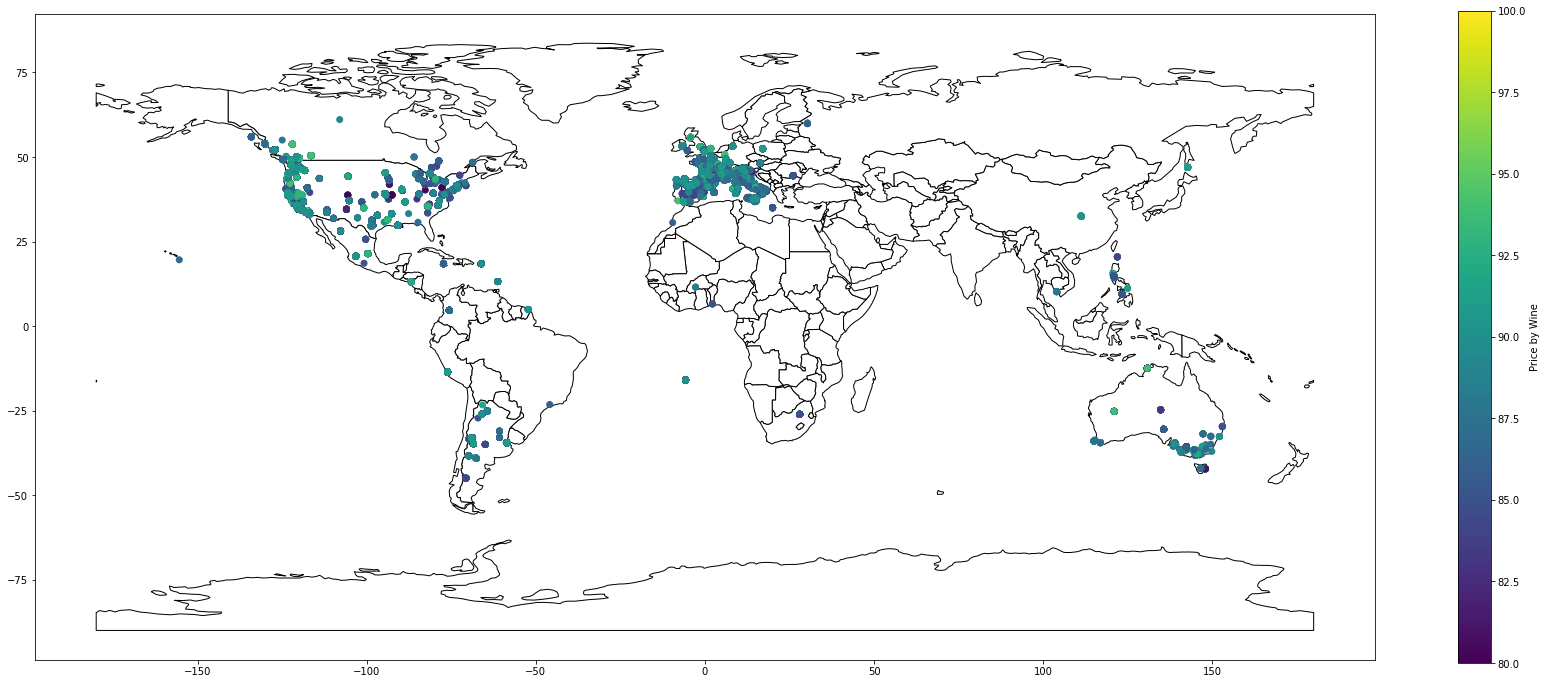

In [41]:
# We restrict to South America.
ax = world.plot(
    color='white', edgecolor='black', figsize=(30,30))
# We can now plot our ``GeoDataFrame``.
# gdf.plot(ax=ax, color='red', figsize=(100, 100), markersize=200)
gdf.plot(ax=ax,
         figsize=(30, 30),
        #  markersize=100,
         column=gdf["points"], 
         legend=True,
         legend_kwds={'label': "Price by Wine", 'orientation': "vertical", 'shrink': 0.4})
      

# ax.set_yticklabels(np.linspace(gdf["points"].max(), gdf["points"].min(), 10, dtype=np.dtype(np.uint64)), {'fontsize': 72})

plt.show()

In [29]:
# X, y = prepare_split_dataset(geo_df, ['X', 'Y', 'Z', 'variety', 'price'], 'points')
# X, y = prepare_split_dataset(geo_df, ['coordinates', 'variety', 'price'], 'points')
X, y = prepare_split_dataset(geo_df, ['country', 'variety', 'price'], 'points')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

NameError: ignored

In [ ]:
X_train.columns

In [ ]:
XGBmodel = xgboost.XGBClassifier(n_estimators=300, max_depth=10)
XGBmodel.fit(X_train, y_train)

In [ ]:
y_train_preds = XGBmodel.predict(X_train)
y_test_preds = XGBmodel.predict(X_test)

In [ ]:
# Accuracy for train
(y_train_preds == y_train).mean() * 100

In [ ]:
# Accuracy for test
(y_test_preds == y_test).mean() * 100